# Coil sketching example code
Welcome!
This notebook shows an example code to run coil sketching with L1-Wavelets reconstruction and radial data.

The modules use the Sigpy library. If you have not set your conda environment yet, please follow the installation instructions in the README.

In [1]:
import os
import sys
sys.path.append('../src')
sys.path.append('../lib')
import numpy as np
import matplotlib.pyplot as plt

import sigpy      as sp
import sketching_mri_app as sk
import stochastic_mri_app as st
from utils import coil_compression

## Setup
Setting up the reconstruction parameters

In [2]:
# Setup
devnum = 0 # Device to use, set to -1 if running in CPU
nc = 8 # number of coils after coil compression
nch = 3 # reduced number of coils
R = 2.5
img_shape = [256,256]
lamda = 5e-2

## Pre-processing steps

In [3]:
#Device configuration
device = sp.Device(devnum)
xp     = device.xp
device.use()
mvd = lambda x: sp.to_device(x, devnum)
mvc = lambda x: sp.to_device(x, sp.cpu_device)

#Loading data
npzfile = np.load('../data/sample_radial.npz')
ksp = npzfile['ksp']
coord = npzfile['coord']
dens = npzfile['dens']

[nc0, nviews0, nread] = ksp.shape
nviews = int(nviews0/R)

# Coil compression steps
ksp, _ = coil_compression(ksp)

# Loading into device
ksp = mvd(ksp[:nc,...])
coord = mvd(coord)
dens = mvd(dens)

ksp_us = mvd(ksp[:nc,:nviews,...])
coord_us = mvd(coord[:nviews,...])
dens_us = mvd(dens[:,:nviews,...])

## Sensitivity maps and reference images 

In [4]:
# Sensitivity map estimation
mps = sp.mri.app.JsenseRecon(ksp_us, coord=coord_us, mps_ker_width=6, lamda=1e-1,
                         img_shape=img_shape, device=device, max_iter=30, show_pbar=True).run()

# Fully-sampled reference
img_fs = sp.mri.app.SenseRecon(ksp, mps, coord=coord, weights=dens, lamda=1e-3,
                                        device=device, max_iter=10, show_pbar=True).run()
img_fs = mvc(img_fs)
# Undersampled image
A_us = sp.mri.linop.Sense(mps, coord=coord_us, weights=dens_us**2)
img_us = np.rot90(mvc(A_us.H*ksp_us), k=-1)
scale = np.percentile(np.abs(img_us.flatten()), 95)

## Reconstructions
We proceed with the main 4 reconstructions in the manuscript:
1. Baseline reconstruction using all $C=8$ coils
2. Aggressive coil compression using $\hat{C} = 3$ coils
3. Accelerated Proximal Stochastic Gradient Descent (AccProxSGD) with batch size $\hat{C} = 3$
4. Coil sketching with reduced number of coils $\hat{C} = 3$

In [5]:
# Baseline reconstruction
max_iter = 20
img_base = scale*sp.mri.app.L1WaveletRecon(ksp_us/scale, mps, lamda, weights=dens_us,
                        coil_batch_size = nch,
                        coord=coord_us, max_iter=max_iter, device=device,
                        show_pbar=True).run()
img_base = np.rot90(mvc(img_base), k=-1)

# Aggressive coil compression reconstruction
max_iter = 20
img_cc = scale*sp.mri.app.L1WaveletRecon(ksp_us[:nch,...]/scale, mps[:nch,...], lamda,
                         weights=dens_us, coord=coord_us, max_iter=max_iter, device=device,
                        show_pbar=True).run()
img_cc = np.rot90(mvc(img_cc), k=-1)

# AccProxSGD reconstruction
max_iter = 20
np.random.seed(1)
img_sgd = scale*st.StochasticL1WaveletRecon(ksp_us/scale, mps, lamda, nch,
                                 weights=dens_us, coord=coord_us, device=device,
                                 max_iter=max_iter, beta=0.95,
                                 show_pbar=True).run()
img_sgd = np.rot90(mvc(img_sgd), k=-1)
# Coil sketching reconstruction
max_init_iter = 4
max_inner_iter = 5
max_outer_iter = 3
np.random.seed(1)
img_sk = scale*sk.SketchedL1WaveletRecon(ksp_us/scale, mps, lamda, nch,
                                 weights=dens_us, coord=coord_us,
                                 show_pbar=True, device=device,
                                 max_init_iter=max_init_iter,
                                 max_outer_iter=max_outer_iter,
                                 max_inner_iter=max_inner_iter).run()
img_sk = np.rot90(mvc(img_sk), k=-1)

Text(0.5, 1.0, 'Coil sketching $\\hat{C}=3$')

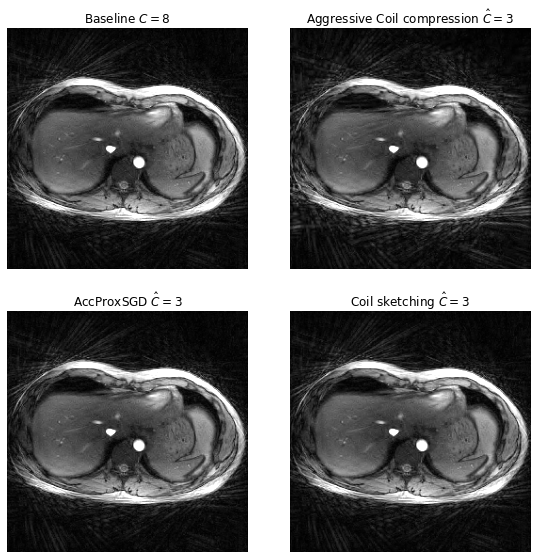

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout() 
ax1.imshow(np.abs(img_base), cmap='gray', vmin=0, vmax=.6)
ax1.axis('off')
ax1.set_title('Baseline $C=8$')

ax2.imshow(np.abs(img_cc), cmap='gray', vmin=0, vmax=.6)
ax2.axis('off')
ax2.set_title('Aggressive Coil compression $\hat{C}=3$')

ax3.imshow(np.abs(img_sgd), cmap='gray', vmin=0, vmax=.6)
ax3.axis('off')
ax3.set_title('AccProxSGD $\hat{C}=3$')

ax4.imshow(np.abs(img_sk), cmap='gray', vmin=0, vmax=.6)
ax4.axis('off')
ax4.set_title('Coil sketching $\hat{C}=3$')